# t-SNE visualization on Oslo transect dataset

The Oslo transect dataset consists of 360 plant samples collected at 40 sites along a 120 km long transect crossing Oslo, Norway (Templ et al., 2008). At  each site nine different plant materials were sampled and they were terrestrial moss (MOS), fern (FER), European mountain ash leaves (ROG), birch leaves (BIL), bark (BBA) and wood (BWO) and spruce needles (SNE), twigs (TWI) and wood (STW). Geochemical concentrations of 37 elements for the sample materials were reported, of which 13 elements were not considered, either due to the high percentage (more than 50%) of censored values or the quality considerations (Reimann et al., 2007).The remaining 24 elements and the results for loss on ignition (LOI) were all above the detection limits and thus is used here to test the performance of t-SNE on visualizing the geochemical data. This dataset is available in the R package “rrcov” as dataset “OsloTransect” (Todorov and Filzmoser, 2010). 

## Load libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

In [23]:
# Dimension reduction and clustering libraries
from scipy.stats import boxcox
from statsmodels.stats.diagnostic import lilliefors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [3]:
# Global plot settings
%matplotlib inline
np.random.seed(10)
plt.style.use('default')

## Load data

In [4]:
# Load data
df = pd.read_csv('OsloTransect.csv', header=0)

# Show the first five rows
df.head(5)

,X.ID,X.MAT,XCOO,YCOO,XCOO_km,YCOO_km,X.FOREST,DAY,X.WEATHER,ALT,...,Mn,Mo,Ni,P,Pb,S,Sb,Sr,Ti,Zn
0,101,BIL,578741,6708487,578.741,6708.487,SPRBIR,6,NICE,218,...,657.0,0.04,1.5,1790.0,0.37,1500.0,0.03,41.8,7.0,122.2
1,102,BIL,582865,6706649,582.865,6706.649,SPRBIR,6,NICE,431,...,1669.0,0.04,2.9,2490.0,0.39,1700.0,0.03,30.4,11.0,297.0
2,103,BIL,581155,6720326,581.155,6720.326,SPRBIR,7,RAIN,430,...,2584.0,0.07,2.2,2490.0,0.68,1300.0,0.02,29.5,10.0,192.0
3,104,BIL,580482,6711512,580.482,6711.512,SPRBIR,7,MOIST,475,...,2444.0,0.04,1.7,2670.0,0.43,1300.0,0.02,22.9,11.0,274.3
4,105,BIL,584618,6701621,584.618,6701.621,SPRUCE,8,MOIST,410,...,769.0,0.03,3.7,2040.0,0.38,1800.0,0.03,34.1,9.0,99.4


## Preprocessing

In [5]:
# Step 1 : Feature selection
pars = ['Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']
X_df = df[pars]

# Step 2 : Substitution of censored values
# There is no censored values in this dataset

# Step 3 : Screening the non-measurement values
X_df = X_df.replace(-9999, np.nan)
X_df = X_df.dropna(axis=0, how='any')

# Step 4: Data transformation
X_df_log = np.log(X_df)

# Step 5 : Standardization 
X = X_df_log.values
rescaledX = StandardScaler().fit_transform(X)


In [6]:
# Print the remianing number of samples 
n_samples, n_parameters = rescaledX.shape
print('Number of samples:', n_samples, '\nNumber of variables:', n_parameters)

Number of samples: 350 
Number of variables: 25


In [7]:
# Get the true lables for the remianing samples
Y_df = df[['X.ID', 'X.MAT', 'XCOO', 'YCOO', 'Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']].dropna(axis=0, how='any')
Y_df['MATID'] = Y_df['X.MAT'] + Y_df['X.ID'].map(str)  

print(Y_df['X.MAT'].unique())


['BIL' 'BBA' 'BWO' 'FER' 'ROG' 'MOS' 'STW' 'SNE' 'TWI']


## Check the distributions

### Log-transformation 

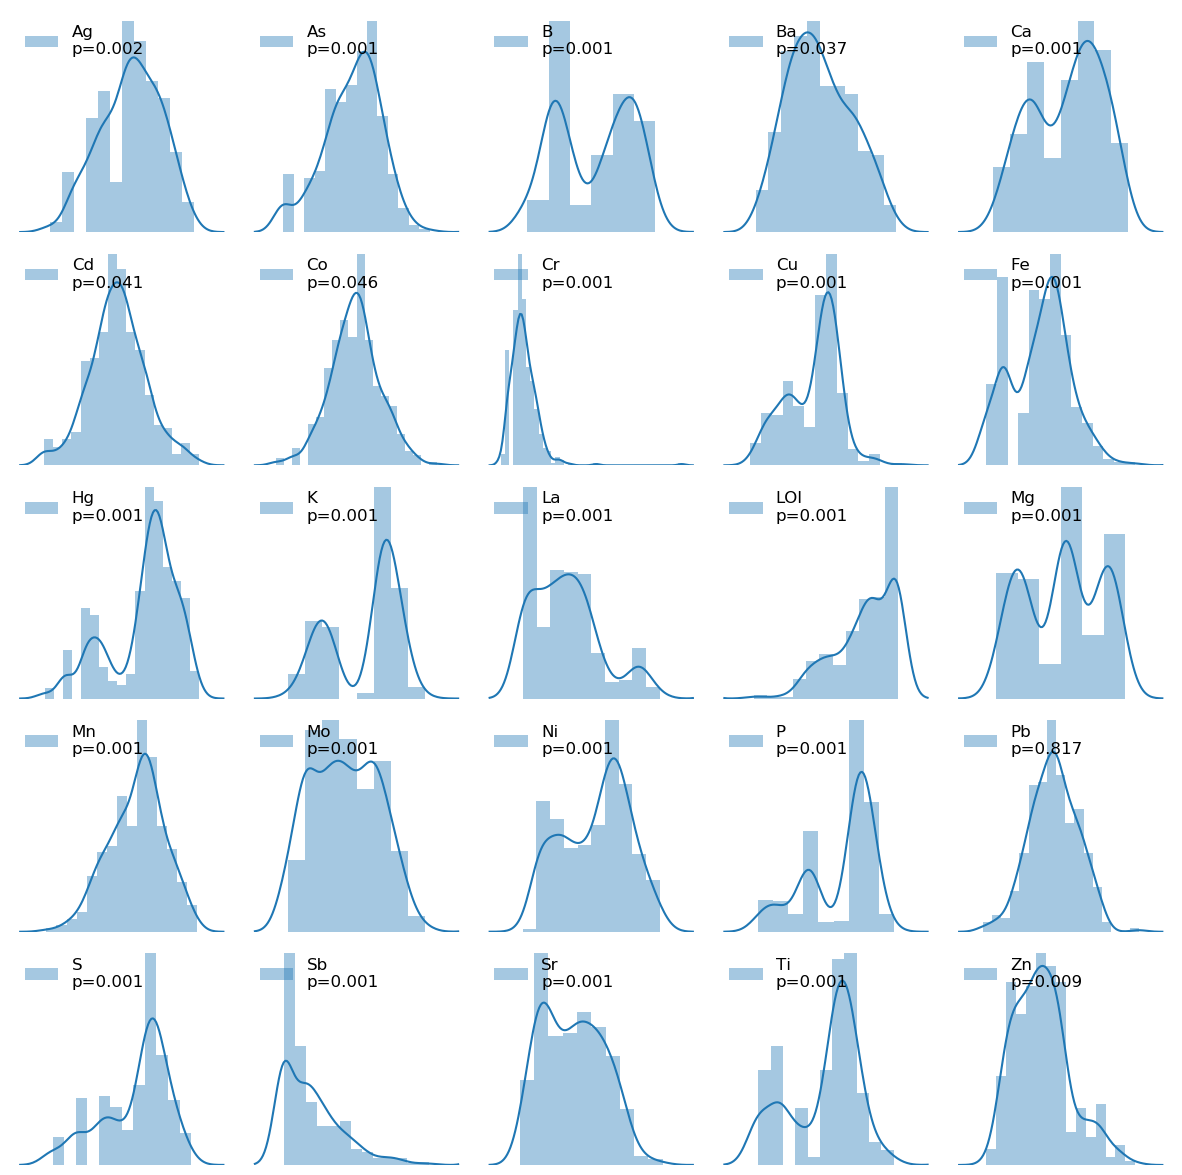

In [8]:
plt.figure(figsize=(15, 15))
i = 1
for par in ['Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']:
    plt.subplot(5, 5, i)
    ksstat, pvalue = lilliefors(X_df_log[par].values, pvalmethod='table')
    
    if par == 'Ag_ppb':
        sns.distplot(X_df_log[par], hist=True, kde=True, label=('Ag' + '\np=%.3f' %pvalue)) 
    elif par == 'As_ash':
        sns.distplot(X_df_log[par], hist=True, kde=True, label=('As' + '\np=%.3f' %pvalue)) 
    elif par == 'Hg_ppb':
        sns.distplot(X_df_log[par], hist=True, kde=True, label=('Hg' + '\np=%.3f' %pvalue)) 
    else:
        sns.distplot(X_df_log[par], hist=True, kde=True, label=(par + '\np=%.3f' %pvalue))

    plt.axis('off')
    plt.legend(frameon=False, loc='upper left', fontsize=12)
    i = i + 1

plt.subplots_adjust(hspace=0.05, wspace=0.05)

### Box-cox transformation

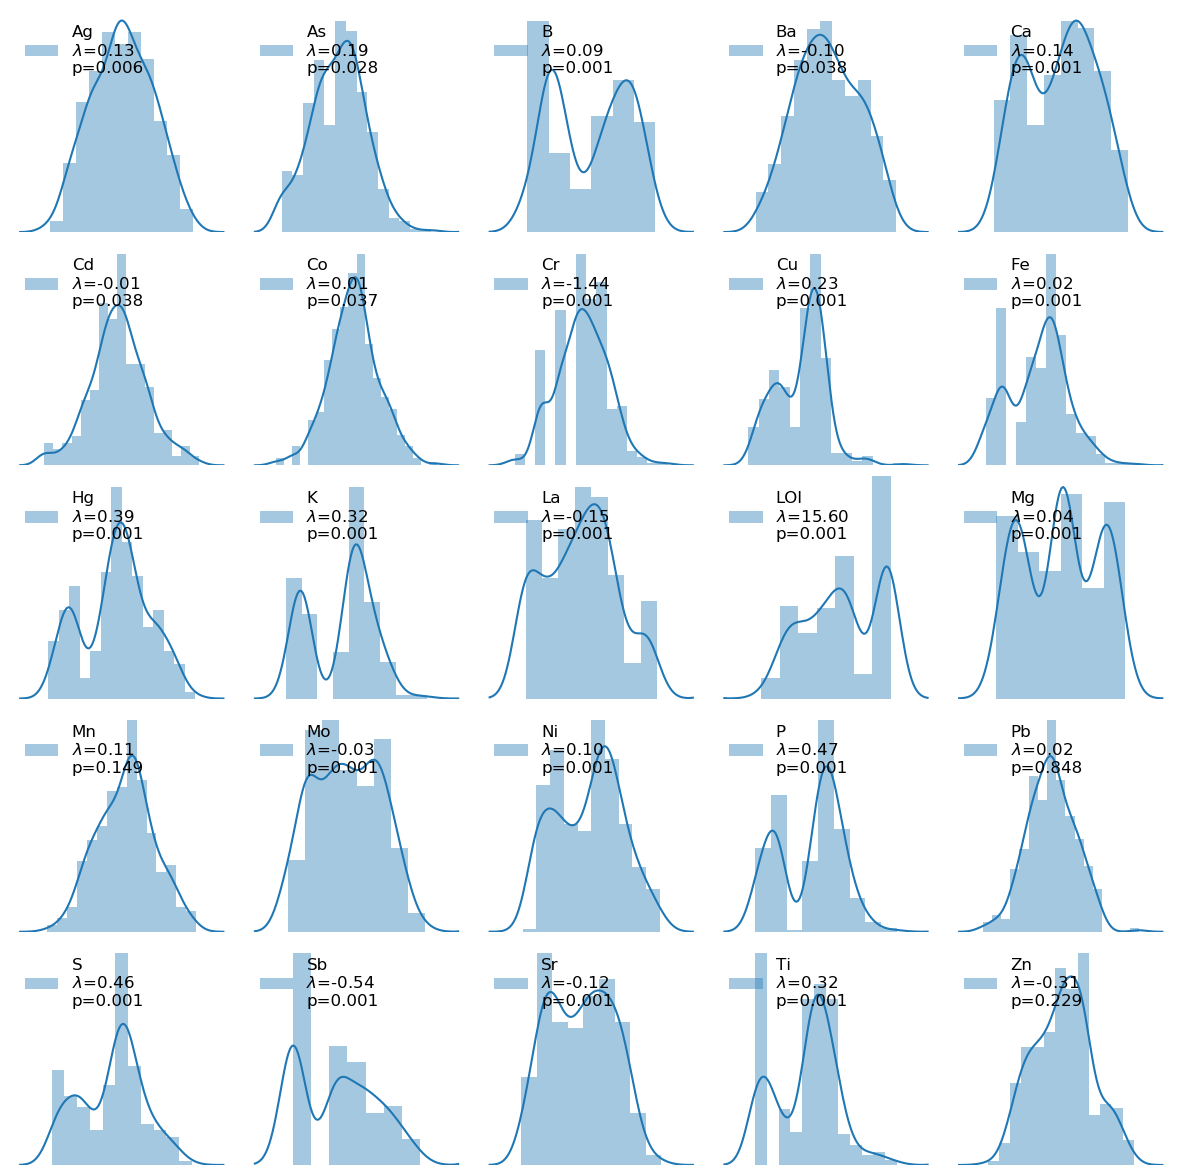

In [9]:
plt.figure(figsize=(15, 15))

i = 1
for par in ['Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']:
    plt.subplot(5, 5, i)
    fitted_data, fitted_lambda = boxcox(X_df[par].values) 
    ksstat, pvalue = lilliefors(fitted_data, pvalmethod='table')
    if par == 'Ag_ppb':
        sns.distplot(fitted_data, hist=True, kde=True, label=('Ag' + '\n'+'$\lambda$' + '=%.2f\np=%.3f' %(fitted_lambda, pvalue))) 
    elif par == 'As_ash':
        sns.distplot(fitted_data, hist=True, kde=True, label=('As' + '\n'+'$\lambda$' + '=%.2f\np=%.3f' %(fitted_lambda, pvalue))) 
    elif par == 'Hg_ppb':
        sns.distplot(fitted_data, hist=True, kde=True, label=('Hg' + '\n'+'$\lambda$' + '=%.2f\np=%.3f' %(fitted_lambda, pvalue))) 
    else:
        sns.distplot(fitted_data, hist=True, kde=True, label=(par + '\n'+'$\lambda$' + '=%.2f\np=%.3f' %(fitted_lambda, pvalue))) 
    
     
    #plt.text()
    plt.axis('off')
    plt.legend(frameon=False, loc='upper left', fontsize=12)
    i = i + 1

plt.subplots_adjust(hspace=0.05, wspace=0.05)

## Statistical  analysis

### HCA analysis

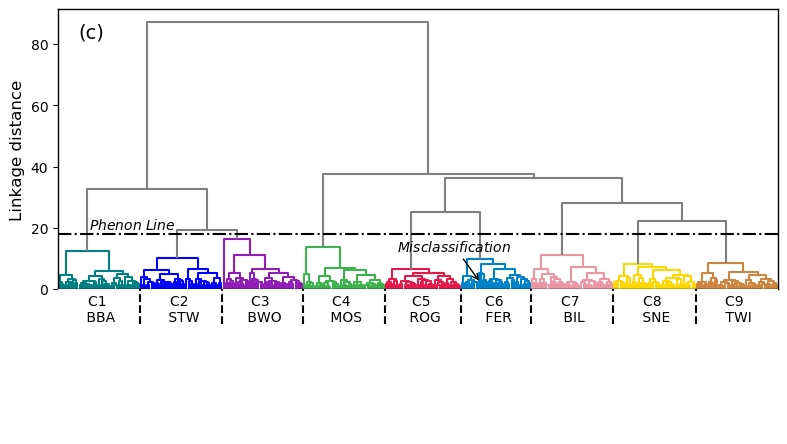

Number of clusters: 9
Samples in each cluster: [40, 40, 39, 40, 37, 34, 40, 40, 40]


In [10]:
# Ward method
Z = hierarchy.linkage(rescaledX, method='ward', metric='euclidean')

# Set the location of phenon line
max_d = 18   

# Figure settings
fig = plt.figure(figsize=(9, 7))

# Axis settings
left, bottom, width, height = 0.1, 0.3, 0.8, 0.4
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors of the nine clusters
colors=['#008080', 'blue', '#911eb4', '#3cb44b', '#e6194b', '#0082c8', '#EA96A3', 'gold', 'peru']
# colors=['#EA96A3', '#E19153', '#B89C49', '#60AE47', '#4BABA4', '#4FABBC', '#6DAEE2', '#B6A8EB', '#DF8FE7']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=0, color_threshold=max_d, above_threshold_color='grey')
hierarchy.set_link_color_palette(None)
ax1.axhline(y=18, linestyle='-.', color='k')
ax1.set_xlabel('sample index')
ax1.set_ylabel('Linkage distance', fontsize=12)
ax1.set_xticks([])

# Calculate number of clusters under the linkage distance of max_d
n_clusters = np.max(np.unique(hierarchy.fcluster(Z, max_d, criterion='distance')))

# Calculate the number of samples for each cluster
cluster_size = [np.sum(hierarchy.fcluster(Z, max_d, criterion='distance')==i + 1) for i in range(n_clusters)]

# Plot the one misclassification
# ax1.plot([2045, 2045], [0, 5.12], color='#e6194b')
ax1.annotate('$Misclassification$',
             xy=(2055, 2), xycoords='data',
             xytext=(-60, 23), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))
ax1.text(150, 19.5, '$Phenon$' + ' ' + '$Line$')

ax1.text(100, 82, '(c)', fontsize=14)
ax1.spines['top'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['right'].set_linewidth(1)

# The bottom figure showing the cluster names
left, bottom, width, height = 0.1, 0.1, 0.8, 0.2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, n_samples * 10)
ax2.set_ylim(0, 2)

# Dot line to split each cluster 
cum_cluster_szie = np.cumsum(cluster_size) * 10
for i in range(8):
    ax2.plot([cum_cluster_szie[i], cum_cluster_szie[i]], [1.5, 2], linestyle='--', color='k', lw=1.5) 
    
ax2.set_xticks([])
ax2.set_yticks([])
    
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax2.text(0                   + (cum_cluster_szie[0] -                   0) / 2, 1.5, 'C1 \n BBA', ha='center', va='bottom')
ax2.text(cum_cluster_szie[0] + (cum_cluster_szie[1] - cum_cluster_szie[0]) / 2, 1.5, 'C2 \n STW', ha='center', va='bottom')
ax2.text(cum_cluster_szie[1] + (cum_cluster_szie[2] - cum_cluster_szie[1]) / 2, 1.5, 'C3 \n BWO', ha='center', va='bottom')
ax2.text(cum_cluster_szie[2] + (cum_cluster_szie[3] - cum_cluster_szie[2]) / 2, 1.5, 'C4 \n MOS', ha='center', va='bottom')
ax2.text(cum_cluster_szie[3] + (cum_cluster_szie[4] - cum_cluster_szie[3]) / 2, 1.5, 'C5 \n ROG', ha='center', va='bottom')
ax2.text(cum_cluster_szie[4] + (cum_cluster_szie[5] - cum_cluster_szie[4]) / 2, 1.5, 'C6 \n FER', ha='center', va='bottom')
ax2.text(cum_cluster_szie[5] + (cum_cluster_szie[6] - cum_cluster_szie[5]) / 2, 1.5, 'C7 \n BIL', ha='center', va='bottom')
ax2.text(cum_cluster_szie[6] + (cum_cluster_szie[7] - cum_cluster_szie[6]) / 2, 1.5, 'C8 \n SNE', ha='center', va='bottom')
ax2.text(cum_cluster_szie[7] + (cum_cluster_szie[8] - cum_cluster_szie[7]) / 2, 1.5, 'C9 \n TWI', ha='center', va='bottom')

plt.show()

# Output the cluster indeices
cluster_ids = hierarchy.fcluster(Z, t=18, criterion='distance')

print('Number of clusters:', n_clusters)
print('Samples in each cluster:', cluster_size)

### PCA analysis

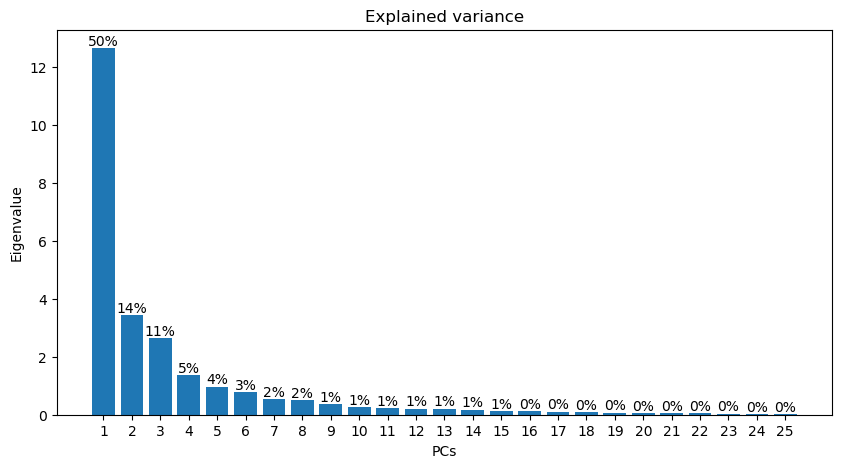

In [11]:
# Perform PCA analysis
pca = PCA(n_components=n_parameters).fit(rescaledX)

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.bar([str(i) for i in range(1, 26)], pca.explained_variance_)
# plt.axhline(y=1, color='grey', linestyle='-.')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Explained variance')

# Attach explained variance ratio above each bar
for i in range(n_parameters):
    height = pca.explained_variance_[i]
    plt.annotate('{:.0f}%'.format(pca.explained_variance_ratio_[i] * 100),
                 xy=(i, height),
                 xytext=(0, 0),  
                 textcoords="offset points",
                 ha='center', va='bottom', 
                 rotation=0, fontsize=10)

plt.show()


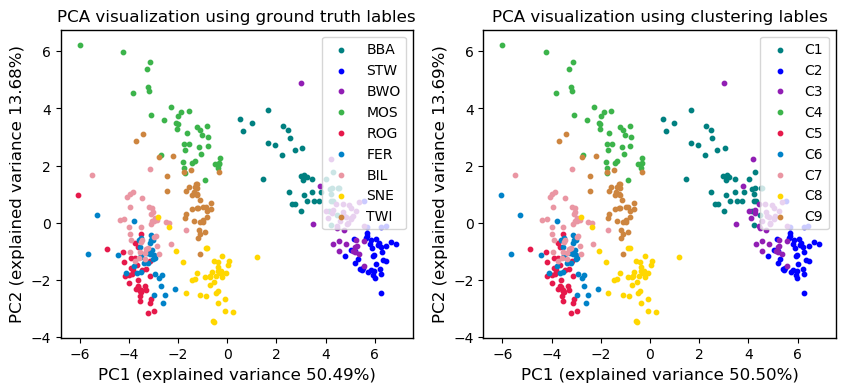

In [12]:
colors=['#008080', 'blue', '#911eb4', '#3cb44b', '#e6194b', '#0082c8', '#EA96A3', 'gold', 'peru']

# Plot the PCA visualization  
pca = PCA(n_components=2)
X_pca = pca.fit_transform(rescaledX)

plt.figure(figsize=(10, 4))

# Using ground truth lables
plt.subplot(121)
plt.scatter(X_pca[Y_df['X.MAT']=='BBA', 0], X_pca[Y_df['X.MAT']=='BBA', 1], color=colors[0], label='BBA', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='STW', 0], X_pca[Y_df['X.MAT']=='STW', 1], color=colors[1], label='STW', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='BWO', 0], X_pca[Y_df['X.MAT']=='BWO', 1], color=colors[2], label='BWO', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='MOS', 0], X_pca[Y_df['X.MAT']=='MOS', 1], color=colors[3], label='MOS', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='ROG', 0], X_pca[Y_df['X.MAT']=='ROG', 1], color=colors[4], label='ROG', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='FER', 0], X_pca[Y_df['X.MAT']=='FER', 1], color=colors[5], label='FER', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='BIL', 0], X_pca[Y_df['X.MAT']=='BIL', 1], color=colors[6], label='BIL', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='SNE', 0], X_pca[Y_df['X.MAT']=='SNE', 1], color=colors[7], label='SNE', s=10)
plt.scatter(X_pca[Y_df['X.MAT']=='TWI', 0], X_pca[Y_df['X.MAT']=='TWI', 1], color=colors[8], label='TWI', s=10)

plt.xlabel('PC1 (explained variance 50.49%)', fontsize=12)
plt.ylabel('PC2 (explained variance 13.68%)', fontsize=12)
plt.title('PCA visualization using ground truth lables', fontsize=12)
plt.legend(loc='upper right')

ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

# Using clustering lables
plt.subplot(122)
plt.scatter(X_pca[cluster_ids[:, ]==1, 0], X_pca[cluster_ids[:, ]==1, 1], color=colors[0], label='C1', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==2, 0], X_pca[cluster_ids[:, ]==2, 1], color=colors[1], label='C2', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==3, 0], X_pca[cluster_ids[:, ]==3, 1], color=colors[2], label='C3', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==4, 0], X_pca[cluster_ids[:, ]==4, 1], color=colors[3], label='C4', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==5, 0], X_pca[cluster_ids[:, ]==5, 1], color=colors[4], label='C5', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==6, 0], X_pca[cluster_ids[:, ]==6, 1], color=colors[5], label='C6', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==7, 0], X_pca[cluster_ids[:, ]==7, 1], color=colors[6], label='C7', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==8, 0], X_pca[cluster_ids[:, ]==8, 1], color=colors[7], label='C8', s=10)
plt.scatter(X_pca[cluster_ids[:, ]==9, 0], X_pca[cluster_ids[:, ]==9, 1], color=colors[8], label='C9', s=10)

plt.xlabel('PC1 (explained variance 50.50%)', fontsize=12)
plt.ylabel('PC2 (explained variance 13.69%)', fontsize=12)
plt.title('PCA visualization using clustering lables', fontsize=12)
plt.legend(loc='upper right')

ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

plt.show()

## t-SNE visualization

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.005s...
[t-SNE] Computed neighbors for 350 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 1.278605
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.067062
[t-SNE] KL divergence after 2000 iterations: 0.217812


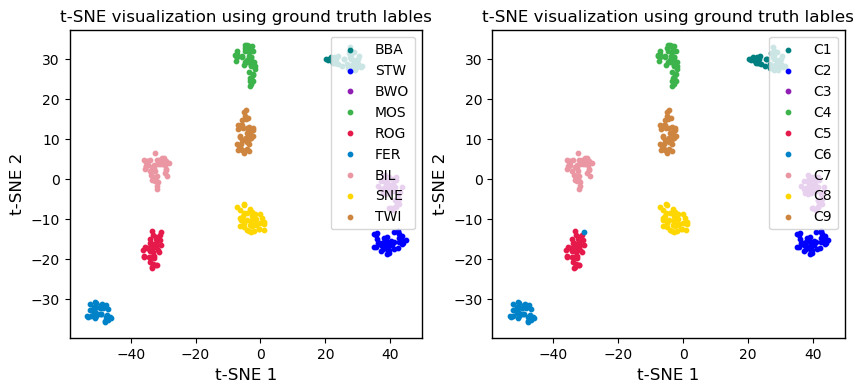

In [13]:
tsne = TSNE(n_components=2,
            init='pca',
            random_state=0, 
            perplexity=20,
            early_exaggeration=12,
            metric='cityblock',
            #method='exact',
            n_iter=2000,
            verbose=1)
X_tsne = tsne.fit_transform(rescaledX)

plt.figure(figsize=(10, 4))

# Using ground truth lables
plt.subplot(121)
plt.scatter(X_tsne[Y_df['X.MAT']=='BBA', 0], X_tsne[Y_df['X.MAT']=='BBA', 1], color=colors[0], label='BBA', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='STW', 0], X_tsne[Y_df['X.MAT']=='STW', 1], color=colors[1], label='STW', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='BWO', 0], X_tsne[Y_df['X.MAT']=='BWO', 1], color=colors[2], label='BWO', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='MOS', 0], X_tsne[Y_df['X.MAT']=='MOS', 1], color=colors[3], label='MOS', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='ROG', 0], X_tsne[Y_df['X.MAT']=='ROG', 1], color=colors[4], label='ROG', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='FER', 0], X_tsne[Y_df['X.MAT']=='FER', 1], color=colors[5], label='FER', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='BIL', 0], X_tsne[Y_df['X.MAT']=='BIL', 1], color=colors[6], label='BIL', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='SNE', 0], X_tsne[Y_df['X.MAT']=='SNE', 1], color=colors[7], label='SNE', s=10)
plt.scatter(X_tsne[Y_df['X.MAT']=='TWI', 0], X_tsne[Y_df['X.MAT']=='TWI', 1], color=colors[8], label='TWI', s=10)

plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('t-SNE visualization using ground truth lables', fontsize=12)
plt.legend(loc='upper right')

ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)

# Using clustering lables
plt.subplot(122)
plt.scatter(X_tsne[cluster_ids[:, ]==1, 0], X_tsne[cluster_ids[:, ]==1, 1], color=colors[0], label='C1', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==2, 0], X_tsne[cluster_ids[:, ]==2, 1], color=colors[1], label='C2', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==3, 0], X_tsne[cluster_ids[:, ]==3, 1], color=colors[2], label='C3', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==4, 0], X_tsne[cluster_ids[:, ]==4, 1], color=colors[3], label='C4', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==5, 0], X_tsne[cluster_ids[:, ]==5, 1], color=colors[4], label='C5', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==6, 0], X_tsne[cluster_ids[:, ]==6, 1], color=colors[5], label='C6', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==7, 0], X_tsne[cluster_ids[:, ]==7, 1], color=colors[6], label='C7', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==8, 0], X_tsne[cluster_ids[:, ]==8, 1], color=colors[7], label='C8', s=10)
plt.scatter(X_tsne[cluster_ids[:, ]==9, 0], X_tsne[cluster_ids[:, ]==9, 1], color=colors[8], label='C9', s=10)

plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title('t-SNE visualization using ground truth lables', fontsize=12)
plt.legend(loc='upper right')

ax = plt.gca()
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)
ax.spines['right'].set_linewidth(1)


## Zoom in part for samples of ROG and FER

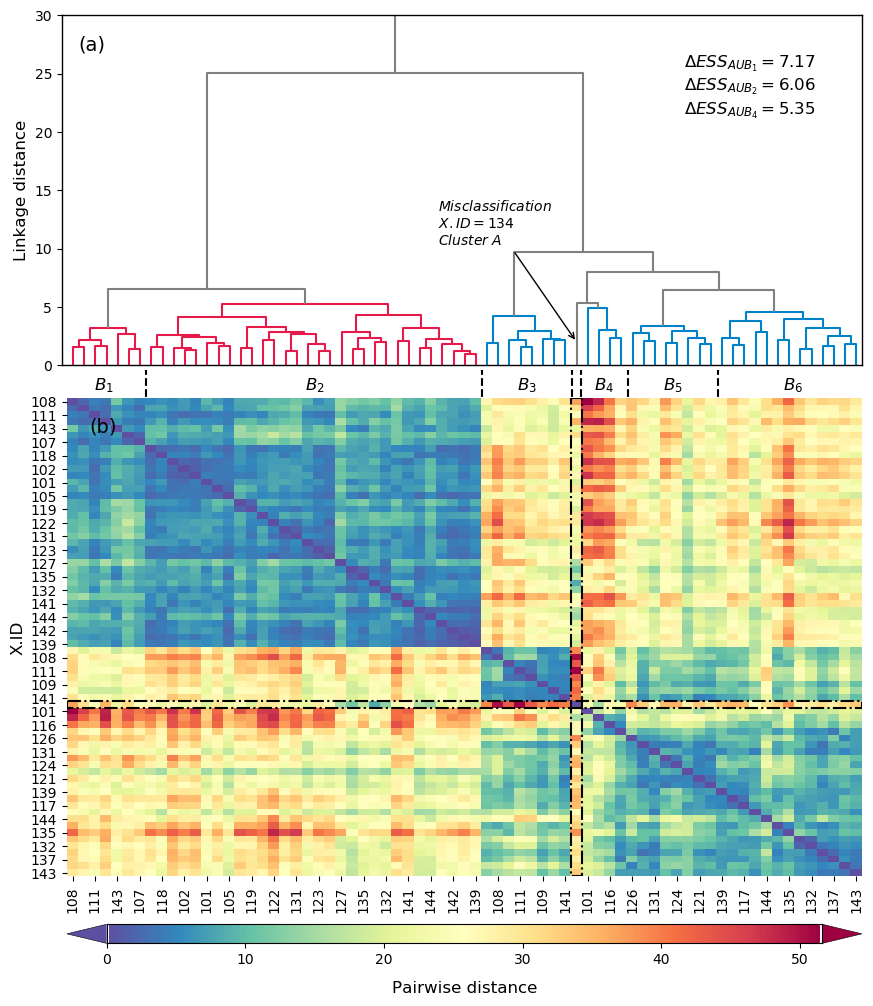

In [14]:
Z = hierarchy.linkage(rescaledX, method='ward', metric='euclidean')

# Set the location of phenon line
max_d = 5.3   

# Figure settings
fig = plt.figure(figsize=(10, 10))

# Axis settings
left, bottom, width, height = 0.1, 0.745, 0.8, 0.35
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors for the nine clusters
colors=['#0082c8', '#0082c8',  '#e6194b', '#e6194b', '#0082c8', '#0082c8']
# colors=['#EA96A3', '#E19153', '#B89C49', '#60AE47', '#4BABA4', '#4FABBC', '#6DAEE2', '#B6A8EB', '#DF8FE7']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=0, color_threshold=max_d, above_threshold_color='grey', labels=list(Y_df['X.ID']))
hierarchy.set_link_color_palette(None)
ax1.set_ylabel('Linkage distance', fontsize=12)
plt.xticks([])

# Calculate number of clusters under the linkage distance of max_d
n_clusters = np.max(np.unique(hierarchy.fcluster(Z, max_d, criterion='distance')))

# Calculate the number of samples for each cluster
cluster_size = [np.sum(hierarchy.fcluster(Z, max_d, criterion='distance')==i + 1) for i in range(n_clusters)]

# Plot the one misclassification
ax1.spines['top'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['right'].set_linewidth(1)

ax1.annotate('$Misclassification$' + '\n' + '$X.ID=134$' + '\n' + '$Cluster$' + ' ' + '$A$',
            xy=(2045, 2), xycoords='data',
            xytext=(-100, 70), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

ax1.text(2200, 25, '$\Delta ESS_{AUB_{1}}=7.17$', ha='center', va='bottom', fontsize=12)
ax1.text(2200, 23, '$\Delta ESS_{AUB_{2}}=6.06$', ha='center', va='bottom', fontsize=12)
ax1.text(2200, 21, '$\Delta ESS_{AUB_{4}}=5.35$', ha='center', va='bottom', fontsize=12)

ax1.text(1600, 27, '(a)',  fontsize=14)

plt.xlim([1585, 2300])
plt.ylim([0, 30])

# The bottom figure
left, bottom, width, height = 0.1, 0.545, 0.8, 0.195
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, n_samples * 10)
ax2.set_ylim(0, 2)

# Dotted line to split each cluster 
ax2.plot([370, 370],   [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([1840, 1840], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2230, 2230], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2270, 2270], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2475, 2475], [1.5, 2], linestyle='--', color='k', lw=1.5) 
ax2.plot([2870, 2870], [1.5, 2], linestyle='--', color='k', lw=1.5)

ax2.text(0    + (370 -0)     / 2, 1.75, '$B_1$', ha='center', va='bottom', fontsize=12)
ax2.text(370  + (1840 -370)  / 2, 1.75, '$B_2$', ha='center', va='bottom', fontsize=12)
ax2.text(1840 + (2230 -1840) / 2, 1.75, '$B_3$', ha='center', va='bottom', fontsize=12)
ax2.text(2270 + (2475 -2270) / 2, 1.75, '$B_4$', ha='center', va='bottom', fontsize=12)
ax2.text(2475 + (2870 -2475) / 2, 1.75, '$B_5$', ha='center', va='bottom', fontsize=12)
ax2.text(3200                   , 1.75, '$B_6$', ha='center', va='bottom', fontsize=12)


ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax2.set_xticks([])
ax2.set_yticks([])

from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
import seaborn as sns

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

# Load data. The csv file only contains the samples of FER and ROG. The orders have been processed to match the HCA reults.
pars = ['Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']
ROGFER_df = pd.read_csv('OsloFERROG_Rescaled.csv')
e_df = ROGFER_df[pars]
e_df = e_df.set_index(ROGFER_df['X.ID'])

# Compute euclidean distance
distances = pairwise_distances(e_df.values, metric='euclidean', squared=True)

df_D = pd.DataFrame(data=distances)

# Axis settings
left, bottom, width, height = 0.105, 0.167, 0.795, 0.545
ax3 = fig.add_axes([left, bottom, width, height])

cf1 = sns.heatmap(df_D, cmap="Spectral_r", cbar=False)#, cbar_kws={'label': 'Pairwise distance', 'orientation': 'horizontal'})

# plt.xticks([])
# plt.yticks([])
ax = plt.gca()
ax.set_xticklabels(e_df.index[::2], rotation=90)
ax.set_yticklabels(e_df.index[::2], rotation=0)

ax.set_ylabel('X.ID', fontsize=12)

ax.plot([45, 46, 46, 45, 45], [0.0, 0.0, 71, 71, 0.0], 'k-.')
ax.plot([0.0, 0.0, 71, 71, 0.0], [45, 46, 46, 45, 45], 'k-.')

# Colorbar settings
ax_divider = make_axes_locatable(ax)
# define size and padding of axes for colorbar
cax = ax_divider.append_axes('bottom', size = '4%', pad = '10%')
# make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
cb1 = colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal',  extend="both")
# locate colorbar ticks

#cb1 = plt.colorbar(cf1, extend="both")
cb1.ax.set_xticks([0, 10, 20, 30, 40, 50])
cb1.ax.set_xticklabels(labels=['0', '10', '20', '30', '40', '50'], fontsize=10)
cb1.ax.set_xlabel("Pairwise distance", rotation=0, labelpad=10, fontsize=12)

ax.text(2, 5, '(b)',  fontsize=14)

plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 1.436539


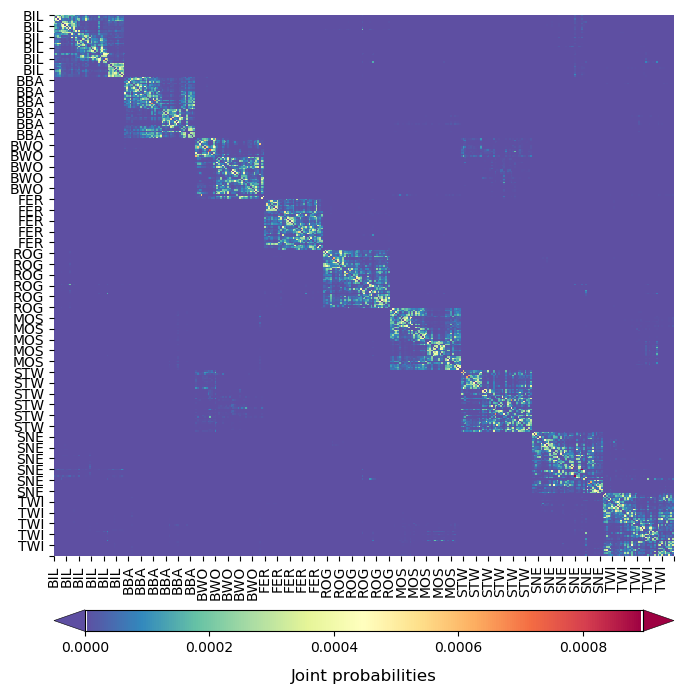

In [15]:
from scipy.spatial.distance import squareform
from sklearn.manifold.t_sne import _joint_probabilities

# Compute euclidean distance
distances = pairwise_distances(rescaledX, metric='euclidean', squared=True)

# Compute joint probabilities p_ij from distances
P = np.float64(squareform(_joint_probabilities(distances=distances, desired_perplexity=20, verbose=True)))

df_P = pd.DataFrame(data=P)
df_P.set_index(Y_df['X.MAT'])
plt.figure(figsize=(8, 8))
sns.heatmap(df_P, cmap='Spectral_r', cbar=False)

ax = plt.gca()
ax.set_xticks(np.linspace(0, 350, 51))
ax.set_yticks(np.linspace(0, 350, 51))
ax.set_xticklabels(Y_df['X.MAT'][::7], rotation=90)
ax.set_yticklabels(Y_df['X.MAT'][::7], rotation=0)

# Colorbar settings
ax_divider = make_axes_locatable(ax)
# Define size and padding of axes for colorbar
cax = ax_divider.append_axes('bottom', size = '4%', pad = '10%')
# Make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
cb1 = colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal',  extend="both")

# Locate colorbar ticks
# cb1 = plt.colorbar(cf1, extend="both")
# cb1.ax.set_xticks([0, 10, 20, 30, 40, 50])
# cb1.ax.set_xticklabels(labels=['0', '10', '20', '30', '40', '50'], fontsize=10)
cb1.ax.set_xlabel('Joint probabilities', rotation=0, labelpad=10, fontsize=12)


plt.show()


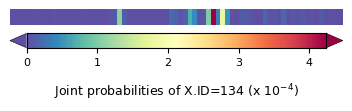

In [16]:
# Get the joint probaibality of the sample X.ID = 134 of ROG 
Prob_ROG134 = df_P.iloc[180, :].values

# Reorder the index to match with the pawrise distance 
index_lables = ROGFER_df['MATID'].values

Prob_ROG134_reordered = np.zeros(len(index_lables))
for i in range(len(index_lables)):
    index = np.argwhere(Y_df['MATID'].values==index_lables[i])[0][0]
    Prob_ROG134_reordered[len(index_lables)-1-i]=Prob_ROG134[index]
    
Prob_ROG134_reordered = Prob_ROG134_reordered.reshape(1, -1)


# Plot joint probaibality
plt.figure(figsize=(4.295, 0.5))
sns.heatmap(Prob_ROG134_reordered, cmap='Spectral_r', cbar=False, annot=False)

ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticklabels('X.ID=134', rotation=90, fontsize=10)
# ax.set_xticklabels(ROGFER_df['MATID'][::2], rotation=90)

ax.tick_params(axis='both', which='major', pad=20)


# Colorbar settings
ax_divider = make_axes_locatable(ax)
# Define size and padding of axes for colorbar
cax = ax_divider.append_axes('bottom', size = '90%', pad = '50%')
# Make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
cb1 = colorbar(ax.get_children()[0], cax = cax, orientation = 'horizontal',  extend="both")

# Locate colorbar ticks
# cb1 = plt.colorbar(cf1, extend="both")
# cb1.ax.set_xticks([0, 10, 20, 30, 40, 50])
cb1.ax.set_xticklabels(labels=['0', '1', '2', '3', '4'], fontsize=8)
cb1.ax.set_xlabel('Joint probabilities of X.ID=134 (x ' +'$10^{-4}$' + ')', rotation=0, labelpad=10, fontsize=9)

plt.show()



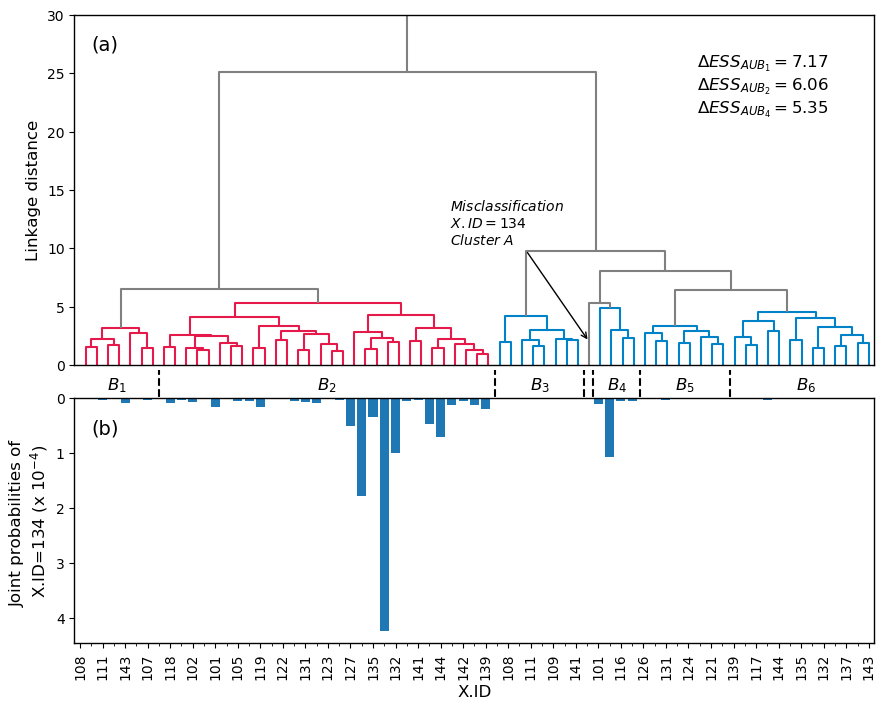

In [17]:
Z = hierarchy.linkage(rescaledX, method='ward', metric='euclidean')

# Set the location of phenon line
max_d = 5.3   

# Figure settings
fig = plt.figure(figsize=(10, 10))

# Axis settings
left, bottom, width, height = 0.1, 0.745, 0.8, 0.35
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors for the nine clusters
colors=['#0082c8', '#0082c8',  '#e6194b', '#e6194b', '#0082c8', '#0082c8']
# colors=['#EA96A3', '#E19153', '#B89C49', '#60AE47', '#4BABA4', '#4FABBC', '#6DAEE2', '#B6A8EB', '#DF8FE7']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=0, color_threshold=max_d, above_threshold_color='grey', labels=list(Y_df['X.ID']))
hierarchy.set_link_color_palette(None)
ax1.set_ylabel('Linkage distance', fontsize=12)
plt.xticks([])

# Calculate number of clusters under the linkage distance of max_d
n_clusters = np.max(np.unique(hierarchy.fcluster(Z, max_d, criterion='distance')))

# Calculate the number of samples for each cluster
cluster_size = [np.sum(hierarchy.fcluster(Z, max_d, criterion='distance')==i + 1) for i in range(n_clusters)]

# Plot the one misclassification
ax1.spines['top'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)
ax1.spines['right'].set_linewidth(1)

ax1.annotate('$Misclassification$' + '\n' + '$X.ID=134$' + '\n' + '$Cluster$' + ' ' + '$A$',
            xy=(2045, 2), xycoords='data',
            xytext=(-100, 70), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

ax1.text(2200, 25, '$\Delta ESS_{AUB_{1}}=7.17$', ha='center', va='bottom', fontsize=12)
ax1.text(2200, 23, '$\Delta ESS_{AUB_{2}}=6.06$', ha='center', va='bottom', fontsize=12)
ax1.text(2200, 21, '$\Delta ESS_{AUB_{4}}=5.35$', ha='center', va='bottom', fontsize=12)

ax1.text(1600, 27, '(a)',  fontsize=14)

plt.xlim([1585, 2300])
plt.ylim([0, 30])

# The bottom figure
left, bottom, width, height = 0.1, 0.545, 0.8, 0.195
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, n_samples * 10)
ax2.set_ylim(0, 2)

# Dotted line to split each cluster 
ax2.plot([370, 370],   [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([1840, 1840], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2230, 2230], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2270, 2270], [1.5, 2], linestyle='--', color='k', lw=1.5)  
ax2.plot([2475, 2475], [1.5, 2], linestyle='--', color='k', lw=1.5) 
ax2.plot([2870, 2870], [1.5, 2], linestyle='--', color='k', lw=1.5)

ax2.text(0    + (370 -0)     / 2, 1.75, '$B_1$', ha='center', va='bottom', fontsize=12)
ax2.text(370  + (1840 -370)  / 2, 1.75, '$B_2$', ha='center', va='bottom', fontsize=12)
ax2.text(1840 + (2230 -1840) / 2, 1.75, '$B_3$', ha='center', va='bottom', fontsize=12)
ax2.text(2270 + (2475 -2270) / 2, 1.75, '$B_4$', ha='center', va='bottom', fontsize=12)
ax2.text(2475 + (2870 -2475) / 2, 1.75, '$B_5$', ha='center', va='bottom', fontsize=12)
ax2.text(3200                   , 1.75, '$B_6$', ha='center', va='bottom', fontsize=12)


ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax2.set_xticks([])
ax2.set_yticks([])

from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
import seaborn as sns

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

# Load data. The csv file only contains the samples of FER and ROG. The orders have been processed to match the HCA reults.
pars = ['Ag_ppb', 'As_ash', 'B', 'Ba', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg_ppb', 'K', 'La', 'LOI', 'Mg', 'Mn', 'Mo', 'Ni', 'P', 'Pb', 'S', 'Sb', 'Sr', 'Ti', 'Zn']
ROGFER_df = pd.read_csv('OsloFERROG_Rescaled.csv')
e_df = ROGFER_df[pars]
e_df = e_df.set_index(ROGFER_df['X.ID'])

# Compute euclidean distance
distances = pairwise_distances(e_df.values, metric='euclidean', squared=True)

df_D = pd.DataFrame(data=distances)

# Axis settings
left, bottom, width, height = 0.10, 0.467, 0.8, 0.245
ax3 = fig.add_axes([left, bottom, width, height])
ax3.invert_yaxis()
plt.bar(range(71), Prob_ROG134_reordered[0][::-1] * 10000)

# Locater settings
from matplotlib.ticker import AutoMinorLocator
plt.xlim((-0.5, 70.5))
ax3.xaxis.set_minor_locator(AutoMinorLocator(n=2))
plt.xticks(range(0, 71, 2), e_df.index[::2], rotation=90)
plt.xlabel('X.ID', fontsize=12)
plt.ylabel('Joint probabilities of \nX.ID=134 (x ' +'$10^{-4}$' + ')', fontsize=12)

# Plot the one misclassification
ax3.spines['top'].set_linewidth(1)
ax3.spines['bottom'].set_linewidth(1)
ax3.spines['left'].set_linewidth(1)
ax3.spines['right'].set_linewidth(1)

ax3.text(1, 0.65, '(b)',  fontsize=14)

plt.show()


## Cluster validity

### Elbow method

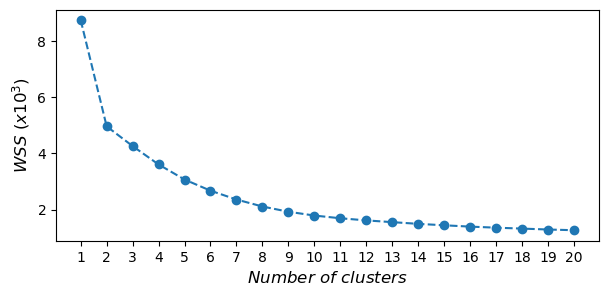

In [57]:
def cmpt_wss(clustering, data, k_max=20):
    
    # Data dimensions
    n_samples, n_features = data.shape
    
    # Perform the clustering
    interia = []
    for k in range(1, k_max + 1):
        clustering.n_clusters = k
        labels = clustering.fit_predict(data)
        centers = [np.mean(data[labels==i, :], axis=0) for i in np.unique(labels)]
        wss = np.sum([np.sum((data[labels==i, :] - centers[i])**2) for i in np.unique(labels)])
        # print('Number of clusters %4d, WSS=%.4f' %(len(np.unique(labels)), wss))
        interia.append(wss)
    return interia

k_max = 20
interia = cmpt_wss(AgglomerativeClustering(), rescaledX, k_max)

plt.figure(figsize=(7, 3))
plt.plot(range(1, k_max + 1), np.array(interia)/1000, 'o--')
plt.xticks(range(1, k_max + 1))
plt.xlabel('$Number\ of\ clusters$', fontsize=12)
plt.ylabel('$WSS\ (x10^3)$', fontsize=12)
plt.show()

### Silhouette method

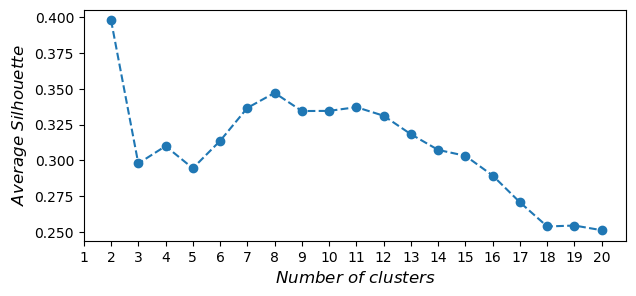

In [58]:
from sklearn.metrics import silhouette_score
def cmpt_silhouette(clustering, data, k_max=20):
    
    silhouette = []
    for k in range(2, kmax + 1):
        clustering.n_clusters = k
        labels = clustering.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette.append(score)
        
    return silhouette

kmax = 20
silhouette = cmpt_silhouette(AgglomerativeClustering(), rescaledX, k_max=20)
plt.figure(figsize=(7, 3))
plt.plot(range(2, k_max + 1), np.array(silhouette), 'o--')
plt.xticks(range(1, k_max + 1))
plt.xlabel('$Number\ of\ clusters$', fontsize=12)
plt.ylabel('$Average\ Silhouette$', fontsize=12)
plt.show()

### Gap statistic

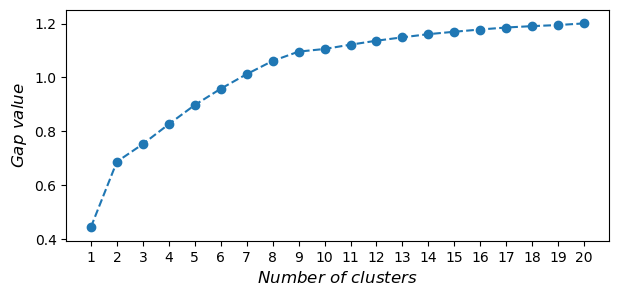

In [62]:
def cmpt_inertia(labels, X):
    
    Dr = np.array([np.sum(pairwise_distances(X[labels==i, :])) for i in np.unique(labels)])
    Nr = np.array([len(X[labels==i, :]) for i in np.unique(labels)])
    return np.sum(Dr / (2 * Nr))

def cmpt_gap(clustering, data, k_max=10, n_references=20):

    # Data dimensions
    n_samples, n_features = data.shape
   
    # Genereate reference datasets within the range
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = np.matrix(np.diag(tops-bots))
    references = np.random.random_sample(size=(n_samples, n_features, n_references))
 
    for i in range(n_references):
        references[:, :, i] = references[:, :, i] * dists + bots
    
    # Clustering the reference datasets
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for i in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(references[:, :, i])
            local_inertia.append(cmpt_inertia(assignments, references[:, :, i]))
            
        sdk = np.sqrt(np.mean((np.log(local_inertia) - np.mean(np.log(local_inertia)))**2))
        sk = np.sqrt(1 + 1/n_references) * sdk
        reference_inertia.append(np.mean(np.log(local_inertia)))
    
    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(cmpt_inertia(assignments, data))
        
    gap = reference_inertia-np.log(ondata_inertia)
    
    return gap, sk, reference_inertia, np.log(ondata_inertia)


k_max = 20
gap, sk, reference_inertia, ondata_inertia = cmpt_gap(AgglomerativeClustering(), rescaledX, k_max)

plt.figure(figsize=(7, 3))
plt.errorbar(range(1, k_max + 1), gap, yerr=2 * sk, fmt='o', linestyle='--')
plt.xticks(range(1, 21))
plt.xlabel('$Number\ of\ clusters$', fontsize=12)
plt.ylabel('$Gap\ value$', fontsize=12)

plt.show()